# March 02, 2020

First notebook for my master's thesis. I'll try to do some basic operations on the lightcurve of a variable star, observed by the TESS satellite. First import the essential libraries for this:

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mp
mp.style.use('seaborn-colorblind')

Then open the lightcurve file of the star EK Dra. There are Python methods for getting this, but here I just downloaded it from the MAST* database by searching with the name of the star and taking the observation n. 159613900. The lightcurve file (`*lc.fits`) is deep in the archive. It comes as a collection of HDUs (header display units). 

\*https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

First check out the HDUs of this file:

In [2]:
hdul = fits.open('tess2019198215352-s0014-0000000159613900-0150-s_lc.fits')
hdul.info()

Filename: tess2019198215352-s0014-0000000159613900-0150-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    161   19337R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   


### The star

According to the TESS documentation pages 31-37, the PRIMARY header mainly contains information about the star in question. Let's check out the size, the temperature, and the coordinates of the star:

In [3]:
hdr0 = hdul[0].header
print("Radius = "+str(hdr0['RADIUS'])+" R_o")
print("Temperature = "+str(hdr0['TEFF'])+" K")
print("RA = %.2f, DEC = %.2f (%s)" % (hdr0['RA_OBJ'],hdr0['DEC_OBJ'],hdr0['RADESYS']))

Radius = 0.98715699 R_o
Temperature = 5647.0 K
RA = 219.75, DEC = 64.29 (ICRS)


Checking the SIMBAD database* we see that this matches the coordinates for EK Dra, so we have the correct star.

This header contains all sorts of other information that may come in handy later.

\*http://simbad.u-strasbg.fr/simbad/sim-id?ident=EK%20Dra%20&NbIdent=1&Radius=30&Radius.unit=arcsec&submit=submit%2Bid

### Lightcurve

The LIGHTCURVE header unit is where the actual data lies. First, let's look at the form of the data:

In [4]:
lcdata = hdul[1].data
lcdata

FITS_rec([(1683.34698746, -0.00138853, 328243, 217622.4 , 50.860905, 2417.4097, 7.7700257,       nan,       nan, 168, nan, nan, nan, nan, 2006.77163089, 0.00020496, 332.09598249, 0.00020995,         nan,         nan),
          (1683.34837631, -0.00138857, 328244, 232000.23, 52.380573, 2222.4485, 7.671241 ,       nan,       nan, 160, nan, nan, nan, nan, 2006.71976696, 0.00018462, 332.13176054, 0.00017755,         nan,         nan),
          (1683.34976516, -0.00138861, 328245, 231992.89, 52.389812, 2226.898 , 7.7000313,       nan,       nan, 160, nan, nan, nan, nan, 2006.71328478, 0.00018479, 332.13610717, 0.00017748,         nan,         nan),
          ...,
          (1710.19924913, -0.00189319, 347577, 232387.3 , 52.43761 , 2306.4365, 7.7169933, 251663.48, 56.778145,   0, nan, nan, nan, nan, 2006.70130284, 0.000185  , 332.12321021, 0.0001778 , -0.00269184, -0.0088167 ),
          (1710.200638  , -0.00189321, 347578, 232559.22, 52.45604 , 2308.133 , 7.727367 , 251532.16, 56.7981  , 

We see a few things here. First, the data itself is in the (redacted) `numpy`-like record from the first row onwards. In the last part of the printout, we see the headers as specified in the TESS documentation p. 33-35. The most important headers are SAP_FLUX and PDCSAP_FLUX, which give us the raw and the PDC-corrected versions of the total electron flux measured by TESS. This is an accurate proxy of the star's lightcurve.

Unfortunately, the PDCSAP_FLUX data seems to suffer from NAN errors in the early parts.

Let's try plotting both PDCSAP_FLUX and SAP_FLUX:

(210000, 260000)

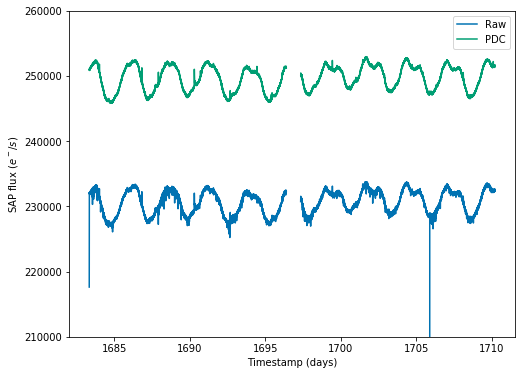

In [5]:
flux = lcdata.field(3)
pdcflux = lcdata.field(7)
time = lcdata.field(0)

def lcplot(t,f):
    mp.rcParams['figure.figsize'] = [8, 6]
    plt.plot(t,f)
    plt.xlabel("Timestamp (days)")
    plt.ylabel(r"SAP flux ($e^-/s$)")
    
    
lcplot(time,flux)
lcplot(time,pdcflux)
plt.legend(["Raw","PDC"])
plt.ylim(210000,260000)

Based on a side-by-side comparison, PDC corrections seem to reduce the sudden "glitches" in the data, as well as do some sort of a uniform upwards correction for the absolute flux. NAN errors in the early data are likely due to insufficient datapoints for the correction; this seems to be fixed afterwards. Since some data is missing anyways (TESS can't always point in the same spot in the sky, etc.) I will need to account for missing data in the analysis.

Let's try out some basic curve fitting here with `scipy`, to see what kinds of issues we might run into when analyzing the data further.

In [6]:
from scipy import optimize as op

def sine(x,a,b,k,p):
    '''A shifted and scaled sin, with scale a, shift b, phase p, and angular fre'''
    return a*np.sin(k*x+p)+b

params_raw, params_raw_cov = op.curve_fit(sine, time, flux)

ValueError: array must not contain infs or NaNs

Alright, we learned one thing: `scipy` does not like NANs. Let's filter them out from the data and redo the fit for the PDC data:

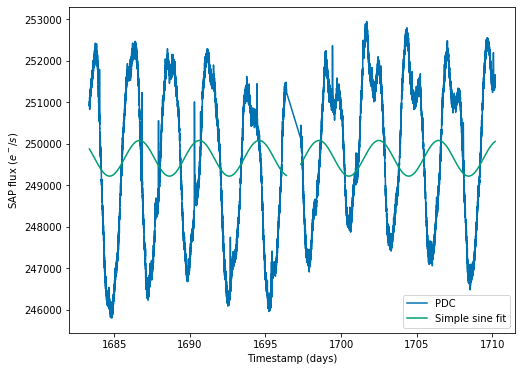

In [7]:
#Filter

pdcflux_filt = pdcflux[~ np.isnan(pdcflux)]
time_filt = time[~ np.isnan(pdcflux)]

# Sine fit
params_pdc, params_cov = op.curve_fit(sine, time_filt, pdcflux_filt)
fit = sine(time,params_pdc[0],params_pdc[1],params_pdc[2],params_pdc[3])

lcplot(time_filt, pdcflux_filt)
lcplot(time, fit)
plt.legend(["PDC","Simple sine fit"])

Oof, sine does not seem to fit at all (as expected).

### Summary:

I learned:

- how to import FITS files in Python

- how to access FITS headers and data tables

- how to check the data for the correct star

- how to filter out NaN values from light curve data

- the benefits of PDC

Next, I will read up on the methods used to detect flares.  - March 02, 2020